# Read input data from external Excel sheets...play with economics then
- External excel sheets have some representative input data...the last one you could use for playing
- Don't change the format in the Excel
- ipynb package might not be there in all Anaconda installations
- Movie output seems unreliable...output to image files works
- You might have to change file and directory names
- There are places where one generates the samples and after that saves them to files. You can speed things up later on by reading the samples from the files and skipping the "computation" i.e. resampling. Running everything is often an overkill.
- Functions here are just for plotting. Tweak as needed
- This one focuses on internal rate of return computations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import matplotlib as mpl
#enable latex editing
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)
import matplotlib.pylab as pylab
params = {'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#might need this to get the movie output working
%matplotlib notebook 

In [3]:
from ipynb.fs.full.NPV_and_LCOE import NPV,NPV2,LCOE,IRR,NPV3  #need: pip install ipynb

In [4]:
filename="./Energy_src_parameters_2019.xlsx"  #Has collection of different parameters from different sources
#some artistic license has been used in adding missing entries

In [5]:
xl = pd.ExcelFile(filename)

In [6]:
names=xl.sheet_names 

In [7]:
print(names)

['Parameters ATB', 'Parameters Fraunhofer 2018', 'Parameters LUT', 'Parameters Narrow', 'Danish data', 'Danish Coal refurbish', 'LUT coal extend', 'EIA', 'EIA existing', 'References']


In [7]:
for i in range(len(names)-1):
    df = pd.read_excel(filename,sheet_name=names[i]) 

In [8]:
#df = pd.read_excel(filename,sheet_name=names[0]) #AT
df = pd.read_excel(filename,sheet_name=names[2]) #LUT
#df = pd.read_excel(filename,sheet_name=names[1]) #Fraunhofer...somewhat
#df = pd.read_excel(filename,sheet_name=names[3]) #Playground with small uncertainty
#df = pd.read_excel(filename,sheet_name=names[5]) #Danish coal life extension
#df = pd.read_excel(filename,sheet_name=names[6]) #LUT coal life extension

In [9]:
print(df.shape)
keynames=df.keys()
dimensions=df.shape

(21, 12)


In [10]:
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend', 'Coal existing'],
      dtype='object')

In [11]:
#How many techs have been implemented? 1st two columns are parameter names and units
ntech=dimensions[1]-2
#How many parameters each have 
nparams=dimensions[0]
print(nparams)

21


#Read the technology data

In [12]:
techdata=np.zeros([nparams,ntech])
#Parameter names
param_names=df[keynames[0]]
print(param_names)

0                        CAPEX min
1                    CAPEX typical
2                        CAPEX max
3                         lifetime
4            Construction time min
5        Construction time typical
6            Construction time max
7                Discount rate min
8                Discount rate max
9              Capacity factor min
10         Capacity factor typical
11             Capacity factor max
12                       FIXED O&M
13                    Variable O&M
14                       Heat rate
15    Fuel cost min primary energy
16    Fuel cost max primary energy
17           Exchange euro to euro
18               Fuel cost min MWh
19               Fuel cost max MWh
20                   CO2 intensity
Name: Roughly LUT parameters, dtype: object


In [13]:
for i in range(ntech):
    #test=pd.DataFrame(df,columns=[keynames[i+2]])
    test=df[keynames[i+2]]
    techdata[:,i]=test[0:]

1. Read the parameters needed for net present value calculation. Careful with the order!
2. Generate random samples for those that are uncertain
3. Compute the NPV for this particular set of parameters

In [14]:
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend', 'Coal existing'],
      dtype='object')

In [15]:
i=2
print(techdata[9,i],techdata[11,i])

0.09 0.12


In [16]:
i=0
x=0
co=0
loopsamples=11
co2min=0
co2max=40.0  #euros/ton CO2
#CO2v=np.linspace(co2min,co2max,loopsamples)
CO2v=np.zeros(loopsamples)
CO2v=np.ones(loopsamples)*0
dmin=-0.05
dmax=0.1
discountv=np.linspace(dmin,dmax,loopsamples)
samples=5000
NPV_techv=np.zeros([samples,loopsamples,ntech])
LCOE_techv=np.zeros([samples,loopsamples,ntech])
It0v=np.zeros([samples,loopsamples,ntech])
rv=np.zeros([samples,loopsamples,ntech])
cfv=np.zeros([samples,loopsamples,ntech])
filename_add='_low_wholesale'   #Add to filenames to clarify
wholesalemin=35-12*0   #20  -12 euros/MWh is about the OECD/NEA 2019 estimate for wind price drop at about 30% penetration
wholesalemax=45-12*0   #80
wholesalemin=70-12*0   #
wholesalemax=90-12*0   #
It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])
n=int(techdata[3,i])
construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
OMfixed=techdata[12,i]
CO2intensity=techdata[20,i]  #tons CO2/MWh
NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesalemin,wholesalemax)/It0
print(NPV_techv[x,co,i])

0.995730386356309


In [49]:
wholesale=0.5*(wholesalemin+wholesalemax)
i=0
#for i in range(ntech):  #just gas and coal i.e. 5 and 7
#for i in range(5,7,2):
tnumh=2
x = (5, 7)
wholesalemin=40
wholesalemax=80
loopsamples=21
wholesalev=np.linspace(wholesalemin,wholesalemax,loopsamples)
internal_rate=np.zeros([tnumh,loopsamples])
ti=0
for i in x:
    print(i)
    for ci in range(loopsamples):
        n=int(techdata[3,i])
        OMfixed=techdata[12,i]
        CO2intensity=techdata[20,i]
        It0=techdata[1,i]
        construction_period=techdata[5,i]
        cf=techdata[10,i]
        OMkwh=(techdata[13,i]+0.5*(techdata[18,i]+techdata[19,i]))/1000
        wholesale=wholesalev[ci]
        internal_rate[ti,ci]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesale)
    ti=ti+1

5
7


In [30]:
print(techdata[10,5])

0.75


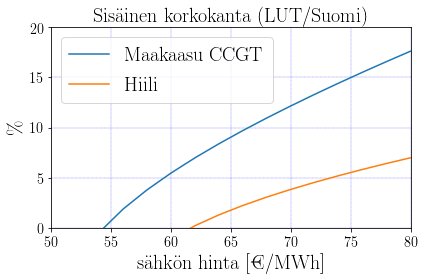

In [31]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(wholesalev,internal_rate[0,:]*100,label='Maakaasu CCGT')
plt.plot(wholesalev,internal_rate[1,:]*100,label='Hiili')
plt.legend(loc='upper left', prop={'size': 20})
plt.title("Sisäinen korkokanta (LUT/Suomi)", fontsize=20)
plt.ylabel("\%", fontsize=20)
plt.xlabel("sähkön hinta [€/MWh]", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.ylim((0,20))
plt.xlim((50,wholesalemax))
plt.tight_layout()
filenamepng= "./IRR_Gas_wholesale.png"
plt.savefig(filenamepng,dpi=150)
plt.show()

In [50]:
#Cheap gas case
wholesale=0.5*(wholesalemin+wholesalemax)
i=0
#for i in range(ntech):  #just gas and coal i.e. 5 and 7
#for i in range(5,7,2):
tnumh=2
x = (5, 7)
wholesalemin=30
wholesalemax=60
loopsamples=21
wholesalev=np.linspace(wholesalemin,wholesalemax,loopsamples)
internal_rate_cheap_gas=np.zeros([tnumh,loopsamples])
ti=0
for i in x:
    print(i)
    for ci in range(loopsamples):
        n=int(techdata[3,i])
        OMfixed=techdata[12,i]
        CO2intensity=techdata[20,i]
        It0=techdata[1,i]
        construction_period=techdata[5,i]
        cf=techdata[10,i]
        OMkwh=(techdata[13,i]+0.5*0.5*(techdata[18,i]+techdata[19,i]))/1000
        wholesale=wholesalev[ci]
        internal_rate_cheap_gas[ti,ci]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesale)
    ti=ti+1

5
7


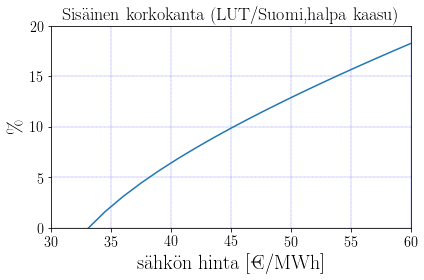

In [40]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(wholesalev,internal_rate_cheap_gas[0,:]*100,label='Maakaasu CCGT')
#plt.plot(wholesalev,internal_rate_cheap_gas[1,:]*100,label='Hiili')
#plt.legend(loc='upper left', prop={'size': 20})
plt.title("Sisäinen korkokanta (LUT/Suomi,halpa kaasu)", fontsize=18)
plt.ylabel("\%", fontsize=20)
plt.xlabel("sähkön hinta [€/MWh]", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.ylim((0,20))
plt.xlim((wholesalemin,wholesalemax))
plt.tight_layout()
filenamepng= "./IRR_Gas_wholesale_cheap_gas.png"
plt.savefig(filenamepng,dpi=150)
plt.show()

4
5
7


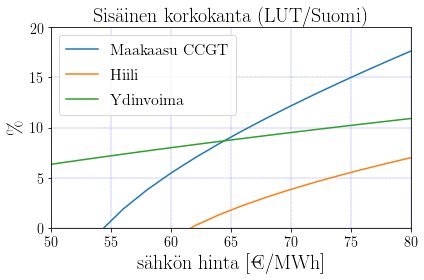

In [46]:
wholesale=0.5*(wholesalemin+wholesalemax)
i=0
#for i in range(ntech):  #just gas and coal i.e. 5 and 7
#for i in range(5,7,2):
tnumh=3
x = (4,5,7)
wholesalemin=40
wholesalemax=80
loopsamples=21
wholesalev=np.linspace(wholesalemin,wholesalemax,loopsamples)
internal_rate=np.zeros([tnumh,loopsamples])
ti=0
for i in x:
    print(i)
    for ci in range(loopsamples):
        n=int(techdata[3,i])
        OMfixed=techdata[12,i]
        CO2intensity=techdata[20,i]
        It0=techdata[1,i]
        construction_period=techdata[5,i]
        cf=techdata[10,i]
        OMkwh=(techdata[13,i]+0.5*(techdata[18,i]+techdata[19,i]))/1000
        wholesale=wholesalev[ci]
        internal_rate[ti,ci]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesale)
    ti=ti+1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(wholesalev,internal_rate[1,:]*100,label='Maakaasu CCGT')
plt.plot(wholesalev,internal_rate[2,:]*100,label='Hiili')
plt.plot(wholesalev,internal_rate[0,:]*100,label='Ydinvoima')
plt.legend(loc='upper left', prop={'size': 16})
plt.title("Sisäinen korkokanta (LUT/Suomi)", fontsize=20)
plt.ylabel("\%", fontsize=20)
plt.xlabel("sähkön hinta [€/MWh]", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.ylim((0,20))
plt.xlim((50,wholesalemax))
plt.tight_layout()
filenamepng= "./IRR_Gas_and_nuclear_coal_wholesale.png"
plt.savefig(filenamepng,dpi=150)
plt.show()

4
5
7


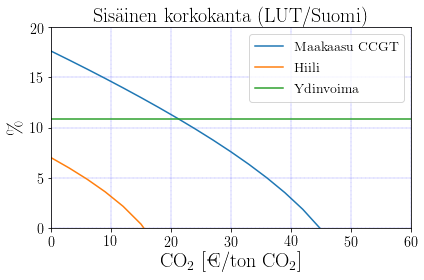

In [86]:
#CO2 price
wholesale=0.5*(wholesalemin+wholesalemax)
i=0
#for i in range(ntech):  #just gas and coal i.e. 5 and 7
#for i in range(5,7,2):
tnumh=3
x = (4,5,7)
co2min=0
co2max=60
loopsamples=21
CO2v=np.linspace(co2min,co2max,loopsamples)
internal_rate=np.zeros([tnumh,loopsamples])
ti=0
for i in x:
    print(i)
    for ci in range(loopsamples):
        n=int(techdata[3,i])
        OMfixed=techdata[12,i]
        CO2intensity=techdata[20,i]
        It0=techdata[1,i]
        construction_period=techdata[5,i]
        cf=techdata[10,i]
        OMkwh=(techdata[13,i]+0.5*(techdata[18,i]+techdata[19,i]))/1000
        wholesale=80
        internal_rate[ti,ci]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[ci]/1000,OMfixed,wholesale)
    ti=ti+1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(CO2v,internal_rate[1,:]*100,label='Maakaasu CCGT')
plt.plot(CO2v,internal_rate[2,:]*100,label='Hiili')
plt.plot(CO2v,internal_rate[0,:]*100,label='Ydinvoima')
plt.legend(loc='upper right', prop={'size': 14})
plt.title("Sisäinen korkokanta (LUT/Suomi)", fontsize=20)
plt.ylabel("\%", fontsize=20)
plt.xlabel("CO$_{2}$ [€/ton CO$_{2}$]", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.ylim((0,20))
plt.xlim((co2min,co2max))
plt.tight_layout()
filenamepng= "./IRR_Gas_and_nuclear_coal_co2.png"
plt.savefig(filenamepng,dpi=150)
plt.show()

Sweep both over CO2 price and the wholesale price

In [90]:
#for i in range(ntech):  #just gas and coal i.e. 5 and 7
#for i in range(5,7,2):
tnumh=3
x = (4,5,7)
wholesalemin=40
wholesalemax=80
loopsamples=17
wholesalev=np.linspace(wholesalemin,wholesalemax,loopsamples)
co2min=0
co2max=60
loopsamples2=15
CO2v=np.linspace(co2min,co2max,loopsamples2)
internal_rate=np.zeros([tnumh,loopsamples2,loopsamples])
ti=0
for i in x:
    print(i)
    for ci in range(loopsamples):
        for ci2 in range(loopsamples2):
            n=int(techdata[3,i])
            OMfixed=techdata[12,i]
            CO2intensity=techdata[20,i]
            It0=techdata[1,i]
            construction_period=techdata[5,i]
            cf=techdata[10,i]
            OMkwh=(techdata[13,i]+0.5*(techdata[18,i]+techdata[19,i]))/1000
            wholesale=wholesalev[ci]
            internal_rate[ti,ci2,ci]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[ci2]/1000,OMfixed,wholesale)
            if (internal_rate[ti,ci2,ci]<0):
                internal_rate[ti,ci2,ci]=0.0
    ti=ti+1

4
5
7


In [33]:
ti=0
internal_rate[ti,:,:].shape

(15, 17)

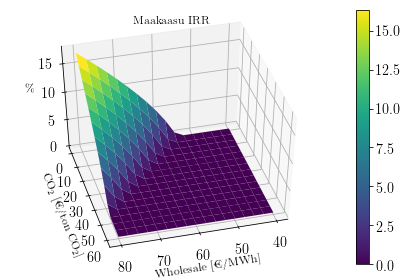

In [95]:
from mpl_toolkits.mplot3d import Axes3D
ti=1   #0 nuclear, 1 gas, 2 coal
X, Y = np.meshgrid(wholesalev,CO2v)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1 = plt.axes(projection='3d')
surf0=ax1.plot_surface(X,Y,internal_rate[ti,:,:]*100, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#ax.clabel(CS, inline=1, fontsize=10)
ax1.view_init(45,75)
ax1.set_title('Maakaasu IRR')
ax1.set_xlabel('Wholesale [€/MWh]', fontsize=12)
ax1.set_ylabel("CO$_{2}$ [€/ton CO$_{2}$]", fontsize=12)
ax1.set_zlabel("\%", fontsize=12)
# Add a color bar which maps values to colors.
fig.colorbar(surf0)
plt.tight_layout()
filenamepng= "./IRR_Gas_3D.png"
plt.savefig(filenamepng,dpi=150)
plt.show()